In [22]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 50)
# pd.set_option('display.max_rows', 50)
import tabula
from pandasql import sqldf
import math
from scipy.stats import chi2
from scipy import stats
from matplotlib import pyplot as plt

-----Protein Layer--------

In [2]:
# integrated dataset
protein_layer = pd.read_excel(r'C:\Users\edwar\Desktop\農藝\paper2\metaData_soybean_drought.xlsx', sheet_name = 'Protein')

# whole genome data
zhou_2022 = pd.read_excel(r'C:\Users\edwar\Desktop\農藝\paper2\data collection\whole genome data\incomplete\protein\Zhou-2022\Zhou2022_iwgd.xlsx')

In [3]:
protein_layer = pd.concat([protein_layer, zhou_2022]).reset_index().drop(['index'], axis = 1)

In [4]:
# import gene_version
glyma_gene_ver = pd.read_csv(r'C:\Users\edwar\Desktop\農藝\paper2\Glyma_genes_correspondence_final.txt', delimiter = '\t')

In [5]:
# 分離成兩種不同基因分數型態
gene_data_score = protein_layer[protein_layer['score'].isna() == False].reset_index().drop(['index'], axis = 1)[['methodology', 'mapped_gene', 'p', 'score', 'gene_version', 'article_name']]
gene_data_p = protein_layer[protein_layer['p'].isna() == False].reset_index().drop(['index'], axis = 1)[['methodology', 'mapped_gene', 'p', 'score', 'gene_version', 'article_name']]

In [6]:
# score分數型態以及 p分數型態的資料有重疊，故要考慮 score以及 p轉換後分數的整合
len(set(gene_data_p['mapped_gene']) & set(gene_data_score['mapped_gene']))

400

In [7]:
gene_data_p.columns = ['methodology', 'gene_org', 'p', 'score', 'gene_version', 'article_name']
gene_data_score.columns = ['methodology', 'gene_org', 'p', 'score', 'gene_version', 'article_name']

In [8]:
# gene_version a2v1 transformed
# p data transformed
gene_data_p_v2 = gene_data_p[gene_data_p['gene_version'] == 2]
gene_data_p_v1 = gene_data_p[gene_data_p['gene_version'] == 1]

gene_data_p_v1 = gene_data_p_v1.merge(glyma_gene_ver[['Wm82.a1.v1', 'Wm82.a2.v1']], how = 'left', left_on = ['gene_org'], right_on = ['Wm82.a1.v1']).drop(['Wm82.a1.v1'], axis = 1).rename(columns = {'Wm82.a2.v1':'gene'})
gene_data_p_v2['gene'] = gene_data_p_v2['gene_org']

gene_data_p = pd.concat([gene_data_p_v1, gene_data_p_v2]).reset_index().drop(['index'], axis = 1)[['methodology', 'gene', 'p', 'score', 'gene_version', 'article_name', 'gene_org']]

# score data transformed (only gene version 1 is in score data)
gene_data_score = gene_data_score.merge(glyma_gene_ver[['Wm82.a1.v1', 'Wm82.a2.v1']], how = 'left', left_on = ['gene_org'], right_on = ['Wm82.a1.v1']).drop(['Wm82.a1.v1'], axis = 1).rename(columns = {'Wm82.a2.v1':'gene'})


C:\Users\edwar\AppData\Local\Temp\ipykernel_1420\1116403056.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_data_p_v2['gene'] = gene_data_p_v2['gene_org']


In [9]:
gene_data_p.head()

,methodology,gene,p,score,gene_version,article_name,gene_org
0,Proteomes,Glyma.01g030500,0.001,NaN,1,Organ-specific proteomics of soybean seedlings...,Glyma01g03720
1,Proteomes,Glyma.02g035000,0.001,NaN,1,Organ-specific proteomics of soybean seedlings...,Glyma02g03990
2,Proteomes,Glyma.02g140900,0.001,NaN,1,Organ-specific proteomics of soybean seedlings...,Glyma02g15910
3,Proteomes,Glyma.03g221400,0.001,NaN,1,Organ-specific proteomics of soybean seedlings...,Glyma03g38000
4,Proteomes,Glyma.19g218300,0.001,NaN,1,Organ-specific proteomics of soybean seedlings...,Glyma19g40610


In [27]:
# pd.DataFrame(Protein_genes['gene'].value_counts()[:100]).reset_index().rename(columns = {'gene':'count', 'index':'gene'}).to_excel(r'C:\Users\edwar\Downloads\protein_genes.xlsx', index = False)

In [9]:
# 整理 p資料
article_list_p = list(gene_data_p['article_name'].unique())
gene_score_data_p = pd.DataFrame()

count = 0
for article in article_list_p:
    gene_data_article_p = gene_data_p[gene_data_p['article_name'] == article]
    gene_list = list(gene_data_article_p['gene'].unique())
    
    for gene in gene_list:
        df_gene = gene_data_article_p[gene_data_article_p['gene'] == gene]
        
        if len(df_gene['gene']) > 1:
            df_gene_v1 = pd.DataFrame()
            p_values = list(df_gene['p'])
            p_value = stats.combine_pvalues(p_values, method = 'fisher')[1]
            df_gene_v1['gene'] = df_gene['gene'].unique()
            df_gene_v1['p'] = p_value
            df_gene_v1['score'] = ''
            df_gene_v1['article_name'] = df_gene['article_name'].unique()
#             df_gene_v1['gene_org'] = df_gene['gene_org'].unique()
            gene_score_data_p = pd.concat([gene_score_data_p, df_gene_v1]).reset_index().drop(['index'], axis = 1)
            
        else:
            gene_score_data_p = pd.concat([gene_score_data_p, df_gene[['gene', 'p', 'score', 'article_name']]]).reset_index().drop(['index'], axis = 1)
            
    count += 1
    print(count)

1
2
3
4
5
6


In [11]:
# 算 sig_flag
gene_score_data_p['sig_flag'] = ''
gene_score_data_p['nonsig_flag'] = ''
p_thres = 0.05

gene_score_data_p.loc[(gene_score_data_p['p'] < p_thres), 'sig_flag'] = 1
gene_score_data_p.loc[(gene_score_data_p['p'] < p_thres), 'nonsig_flag'] = 0

gene_score_data_p.loc[(gene_score_data_p['p'] >= p_thres), 'sig_flag'] = 0
gene_score_data_p.loc[(gene_score_data_p['p'] >= p_thres), 'nonsig_flag'] = 1

In [12]:
# # 算 sig_flag_fv
# gene_list = list(gene_score_data_p['gene'].unique())
# gene_score_data_p_v1 = pd.DataFrame()

# count = 0
# for gene in gene_list:
#     df_gene = gene_score_data_p[gene_score_data_p['gene'] == gene].reset_index().drop(['index'], axis = 1)
    
#     if df_gene['sig_flag'].sum() > df_gene['nonsig_flag'].sum():
#         df_gene['sig_flag_fv'] = '1'  
#     elif df_gene['sig_flag'].sum() == df_gene['nonsig_flag'].sum():
#         df_gene['sig_flag_fv'] = '0'
#     elif df_gene['sig_flag'].sum() < df_gene['nonsig_flag'].sum():
#         df_gene['sig_flag_fv'] = '-1'
    
#     gene_score_data_p_v1 = pd.concat([gene_score_data_p_v1, df_gene]).reset_index().drop(['index'], axis = 1)
#     count += 1
#     if count % 500 == 0:
#         print(count)

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500


In [12]:
# 整合不同篇 report 的 p 值
gene_list = list(gene_score_data_p['gene'].unique())
gene_score_data_p_v1 = pd.DataFrame()

count = 0
for gene in gene_list:
    df_gene = gene_score_data_p[gene_score_data_p['gene'] == gene].reset_index().drop(['index'], axis = 1)
    
    if len(df_gene['gene']) > 1:
        df_gene_v1 = pd.DataFrame()
        p_values = list(df_gene['p'])
        p_value = stats.combine_pvalues(p_values, method = 'fisher')[1]
        df_gene_v1['gene'] = df_gene['gene'].unique()
        df_gene_v1['p'] = p_value
        df_gene_v1['sig_flag'] = df_gene['sig_flag'].sum()
        df_gene_v1['nonsig_flag'] = df_gene['nonsig_flag'].sum()
        gene_score_data_p_v1 = pd.concat([gene_score_data_p_v1, df_gene_v1]).reset_index().drop(['index'], axis = 1)
        
    elif len(df_gene['gene']) == 1:
        gene_score_data_p_v1 = pd.concat([gene_score_data_p_v1, df_gene[['gene', 'p', 'sig_flag', 'nonsig_flag']]]).reset_index().drop(['index'], axis = 1)
    
    count += 1
    if count % 500 == 0:
        print(count)

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500


In [13]:
gene_score_data_p_v1['score'] = -np.log10(gene_score_data_p_v1['p'])

In [14]:
gene_score_data_p_v1['score'].describe()

count    7535.000000
mean        1.724167
std         1.790369
min         0.000208
25%         0.435794
50%         1.093585
75%         2.573481
max        14.461298
Name: score, dtype: float64

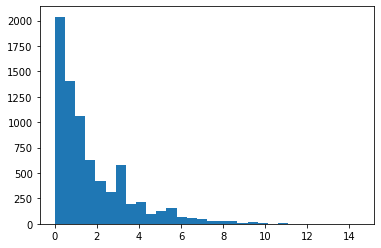

In [16]:
plt.hist(gene_score_data_p_v1['score'], bins = 30)
plt.show()

In [10]:
gene_data_score

,methodology,gene_org,p,score,gene_version,article_name,gene
0,Proteomes,Glyma06g10650,NaN,6.0,1,Gel-Free/Label-Free Proteomic Analysis of Endo...,Glyma.06g101500
1,Proteomes,Glyma02g37120,NaN,5.0,1,Gel-Free/Label-Free Proteomic Analysis of Endo...,Glyma.02g208700
2,Proteomes,Glyma10g37960,NaN,5.0,1,Gel-Free/Label-Free Proteomic Analysis of Endo...,Glyma.10g235100
3,Proteomes,Glyma08g47900,NaN,4.0,1,Gel-Free/Label-Free Proteomic Analysis of Endo...,Glyma.08g363800
4,Proteomes,Glyma01g26950,NaN,4.0,1,Gel-Free/Label-Free Proteomic Analysis of Endo...,Glyma.01g109300
...,...,...,...,...,...,...,...
554,Proteomes,Glyma08g06790,NaN,1.0,1,Medicago truncatula and Glycine max: Different...,Glyma.08g063500
555,Proteomes,Glyma11g12300,NaN,1.0,1,Medicago truncatula and Glycine max: Different...,Glyma.11g115400
556,Proteomes,Glyma11g15230,NaN,1.0,1,Medicago truncatula and Glycine max: Different...,Glyma.11g143400
557,Proteomes,Glyma06g42460,NaN,1.0,1,Medicago truncatula and Glycine max: Different...,Glyma.06g272500


In [11]:
article_list_score = list(gene_data_score['article_name'].unique())
gene_score_data_score = pd.DataFrame()

count = 0
for article in article_list_score:
    gene_data_article_score = gene_data_score[gene_data_score['article_name'] == article]
    gene_list = list(gene_data_article_score['gene'].unique())
    
    for gene in gene_list:
        df_gene = gene_data_article_score[gene_data_article_score['gene'] == gene].reset_index().drop(['index'], axis = 1)
        
        if len(df_gene['gene']) > 1:
            df_gene_v1 = pd.DataFrame()
            df_gene_v1['gene'] = df_gene['gene'].unique()
            # 同篇的分數取最大的 score
            df_gene_v1['score'] = df_gene['score'].max()
            df_gene_v1['p'] = ''
            df_gene_v1['article_name'] = df_gene_v1['article_name']
            gene_score_data_score = pd.concat([gene_score_data_score, df_gene_v1]).reset_index().drop(['index'], axis = 1)
            
        else:
            gene_score_data_score = pd.concat([gene_score_data_score, df_gene[['gene', 'score', 'p', 'article_name']]]).reset_index().drop(['index'], axis = 1)
            
    count += 1
    print(count)

1
2


In [19]:
gene_list = list(gene_score_data_score['gene'].unique())
gene_score_data_score_v1 = pd.DataFrame()

count = 0
for gene in gene_list:
    df_gene = gene_score_data_score[gene_score_data_score['gene'] == gene].reset_index().drop(['index'], axis = 1)
    
    if len(df_gene['gene']) > 1:
        df_gene_v1 = pd.DataFrame()
        df_gene_v1['gene'] = df_gene['gene'].unique()
        df_gene_v1['score'] = df_gene['score'].mean()
        df_gene_v1['p'] = ''
        gene_score_data_score_v1 = pd.concat([gene_score_data_score_v1, df_gene_v1]).reset_index().drop(['index'], axis = 1)
        
    else:
        gene_score_data_score_v1 = pd.concat([gene_score_data_score_v1, df_gene[['gene', 'score', 'p']]]).reset_index().drop(['index'], axis = 1)
    
    count += 1
    if count % 50 == 0:
        print(count)

50
100
150
200
250
300
350
400
450


In [20]:
gene_score_data_score_v1['score'].describe()

count    476.000000
mean       1.194328
std        0.641174
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        6.000000
Name: score, dtype: float64

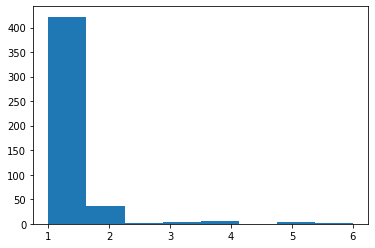

In [21]:
plt.hist(gene_score_data_score_v1['score'], bins = 8)
plt.show()

In [22]:
gene_score_data_score_v1 = gene_score_data_score_v1.rename(columns = {'score':'score_self_designed'})

In [24]:
gene_score_data = gene_score_data_p_v1.merge(gene_score_data_score_v1[['gene', 'score_self_designed']], how = 'outer', on = ['gene'])

In [25]:
gene_score_data.loc[(gene_score_data['score'].isna()), 'score'] = 0
gene_score_data.loc[(gene_score_data['score_self_designed'].isna()), 'score_self_designed'] = 0

In [26]:
gene_score_data['comb_score'] = gene_score_data['score'] + gene_score_data['score_self_designed']

(array([4.506e+03, 1.325e+03, 9.660e+02, 3.970e+02, 2.170e+02, 1.110e+02,
        3.300e+01, 1.300e+01, 6.000e+00, 1.000e+00]),
 array([2.07585525e-04, 1.44631658e+00, 2.89242558e+00, 4.33853458e+00,
        5.78464358e+00, 7.23075258e+00, 8.67686157e+00, 1.01229706e+01,
        1.15690796e+01, 1.30151886e+01, 1.44612976e+01]),
 <a list of 10 Patch objects>)

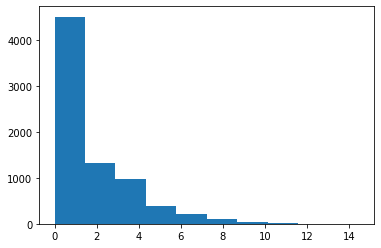

In [27]:
plt.hist(gene_score_data['comb_score'])

In [28]:
ppin = pd.read_csv(r'C:\Users\edwar\Desktop\農藝\paper\paper manuscript and other material revised version\layer data\meta_PPIN.txt', delimiter = '\t', encoding = 'ansi')
ppin.head()

,platform,trait,population,marker,mapped gene,CHR,BP0,BP1,P,LOD,FC,score,N,Rep,Lab/Field,抗性,感性,對照,ref,gene_version,journal,IF(Max)
0,ppin,flooding,soybean,Glyma.02g000100,Glyma.02g000100,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,PlantRegMap,2,NaN,1
1,ppin,flooding,soybean,Glyma.03g000100,Glyma.03g000100,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,PlantRegMap,2,NaN,1
2,ppin,flooding,soybean,Glyma.05g019000,Glyma.05g019000,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,PlantRegMap,2,NaN,1
3,ppin,flooding,soybean,Glyma.06g000100,Glyma.06g000100,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,PlantRegMap,2,NaN,1
4,ppin,flooding,soybean,Glyma.07g000100,Glyma.07g000100,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,PlantRegMap,2,NaN,1


In [29]:
ppin = ppin[['mapped gene', 'score']]
ppin = ppin.rename(columns = {'score':'cluster_score'})

In [31]:
# 若 sig_flag 沒有的就給 0 (比如來自score data的基因)
gene_score_data.loc[(gene_score_data['sig_flag'].isna()), 'sig_flag'] = 0
gene_score_data.loc[(gene_score_data['nonsig_flag'].isna()), 'nonsig_flag'] = 0

In [32]:
# 把 ppin 的東西加上去proteomics的 data
gene_score_data_v1 = gene_score_data.merge(ppin, how = 'outer', left_on = ['gene'], right_on = ['mapped gene'])

In [33]:
gene_score_data_v1.loc[(gene_score_data_v1['gene'].isna()), 'gene'] = gene_score_data_v1['mapped gene']

In [34]:
gene_score_data_v1

,gene,p,sig_flag,nonsig_flag,score,score_self_designed,comb_score,mapped gene,cluster_score
0,Glyma.01g030500,0.004042,1,1,2.393445,0.0,2.393445,Glyma.01g030500,2.0
1,Glyma.02g035000,0.003179,1,1,2.497774,0.0,2.497774,Glyma.02g035000,2.0
2,Glyma.02g140900,0.001000,1,0,3.000000,0.0,3.000000,Glyma.02g140900,2.0
3,Glyma.03g221400,0.001000,1,0,3.000000,0.0,3.000000,Glyma.03g221400,2.0
4,Glyma.19g218300,0.001000,1,0,3.000000,0.0,3.000000,Glyma.19g218300,1.0
...,...,...,...,...,...,...,...,...,...
48368,Glyma.20g249700,NaN,NaN,NaN,NaN,NaN,NaN,Glyma.20g249700,2.0
48369,Glyma.20g249800,NaN,NaN,NaN,NaN,NaN,NaN,Glyma.20g249800,1.0
48370,Glyma.20g249900,NaN,NaN,NaN,NaN,NaN,NaN,Glyma.20g249900,3.0
48371,Glyma.20g250000,NaN,NaN,NaN,NaN,NaN,NaN,Glyma.20g250000,2.0


In [35]:
gene_score_data_v1 = gene_score_data_v1.drop(['mapped gene'], axis = 1)
gene_score_data_v1.loc[(gene_score_data_v1['sig_flag'].isna()), 'sig_flag'] = 0
gene_score_data_v1.loc[(gene_score_data_v1['nonsig_flag'].isna()), 'nonsig_flag'] = 0
gene_score_data_v1.loc[(gene_score_data_v1['score'].isna()), 'score'] = 0
gene_score_data_v1.loc[(gene_score_data_v1['score_self_designed'].isna()), 'score_self_designed'] = 0
gene_score_data_v1.loc[(gene_score_data_v1['comb_score'].isna()), 'comb_score'] = 0

In [36]:
# comb_score = score + score_self_designed + cluster_score
gene_score_data_v1['comb_score'] = gene_score_data_v1['comb_score'] + gene_score_data_v1['cluster_score']

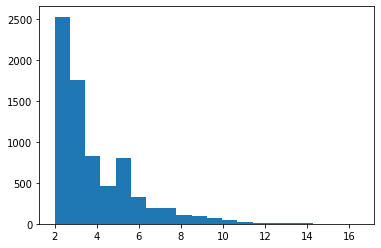

In [37]:
plt.hist(gene_score_data_v1[gene_score_data_v1['comb_score'] > 2]['comb_score'], bins = 20)
plt.show()

# scoring range
# L1 9.5 < x <= max in [5, 6]  #between 150 and 200 
# L2 6.5 < x <= 9.5 in [4, 5]  #595
# L3 4 < x <= 6.5 in [3, 4] #1725
# L4 3 < x <= 4 in [2, 3] #1617
# L5 2 < x <= 3 in [1, 2] #3384
# L6 x < 2 in [0, 1] #40481

In [38]:
# data scaling function
def scale_score(x, upper_b, lower_b, max_val, min_val):
    scaling = (upper_b - lower_b) / (max_val - min_val)
    return (x - min_val) * scaling + lower_b

In [39]:
# L1: coping 9.5 < x < max 
max_val = gene_score_data_v1['comb_score'].max()
min_val = 9.5
gene_score_data_v1_L1 = gene_score_data_v1[(gene_score_data_v1['comb_score'] > min_val) & (gene_score_data_v1['comb_score'] <= max_val)].reset_index().drop(['index'], axis = 1)
upper_b = 6
lower_b = 5

gene_score_data_v1_L1['score_new'] = gene_score_data_v1_L1['comb_score'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [40]:
# L2: coping 6.5 < x <= 9.5
upper_b = 5
lower_b = 4
max_val = 9.5
min_val = 6.5
gene_score_data_v1_L2 = gene_score_data_v1[(gene_score_data_v1['comb_score'] > min_val) & (gene_score_data_v1['comb_score'] <= max_val)].reset_index().drop(['index'], axis = 1)

gene_score_data_v1_L2['score_new'] = gene_score_data_v1_L2['comb_score'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [41]:
# L3 coping 4 < x <= 6.5
upper_b = 4
lower_b = 3
max_val = 6.5
min_val = 4
gene_score_data_v1_L3 = gene_score_data_v1[(gene_score_data_v1['comb_score'] > min_val) & (gene_score_data_v1['comb_score'] <= max_val)].reset_index().drop(['index'], axis = 1)

gene_score_data_v1_L3['score_new'] = gene_score_data_v1_L3['comb_score'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [42]:
# L4 coping 3 < x <= 4
upper_b = 3
lower_b = 2
max_val = 4
min_val = 3
gene_score_data_v1_L4 = gene_score_data_v1[(gene_score_data_v1['comb_score'] > min_val) & (gene_score_data_v1['comb_score'] <= max_val)].reset_index().drop(['index'], axis = 1)

gene_score_data_v1_L4['score_new'] = gene_score_data_v1_L4['comb_score'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [43]:
# L5 coping 2 < x <= 3
upper_b = 2
lower_b = 1
max_val = 3
min_val = 2
gene_score_data_v1_L5 = gene_score_data_v1[(gene_score_data_v1['comb_score'] > min_val) & (gene_score_data_v1['comb_score'] <= max_val)].reset_index().drop(['index'], axis = 1)

gene_score_data_v1_L5['score_new'] = gene_score_data_v1_L5['comb_score'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [44]:
# L6 coping 2 < x <= 3
upper_b = 1
lower_b = 0
max_val = 2
min_val = 0
gene_score_data_v1_L6 = gene_score_data_v1[(gene_score_data_v1['comb_score'] > min_val) & (gene_score_data_v1['comb_score'] <= max_val)].reset_index().drop(['index'], axis = 1)

gene_score_data_v1_L6['score_new'] = gene_score_data_v1_L6['comb_score'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [45]:
# concat six different scoring layer data
gene_score_data_v2 = pd.concat([gene_score_data_v1_L1, gene_score_data_v1_L2, gene_score_data_v1_L3, gene_score_data_v1_L4, gene_score_data_v1_L5, gene_score_data_v1_L6]).reset_index().drop(['index'], axis = 1)

(array([1890., 1494.,  995.,  622., 1192.,  533.,  392.,  204.,  118.,
          10.]),
 array([1.00020759, 1.50018683, 2.00016607, 2.50014531, 3.00012455,
        3.50010379, 4.00008303, 4.50006228, 5.00004152, 5.50002076,
        6.        ]),
 <a list of 10 Patch objects>)

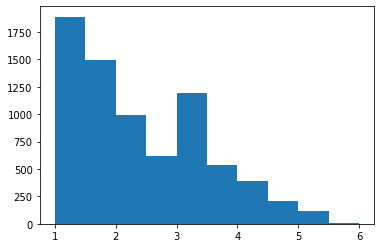

In [46]:
plt.hist(gene_score_data_v2[gene_score_data_v2['score_new'] > 1]['score_new'])

(array([4.0732e+04, 1.9550e+03, 1.5230e+03, 9.2500e+02, 7.4400e+02,
        1.1910e+03, 3.9800e+02, 2.9800e+02, 1.5000e+02, 1.5000e+01]),
 array([0.5 , 1.05, 1.6 , 2.15, 2.7 , 3.25, 3.8 , 4.35, 4.9 , 5.45, 6.  ]),
 <a list of 10 Patch objects>)

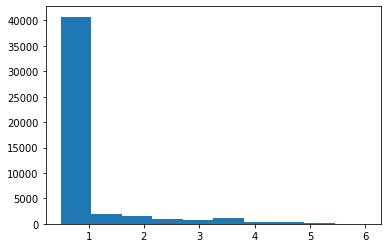

In [47]:
plt.hist(gene_score_data_v2['score_new'])

In [49]:
gene_score_data_v2 = gene_score_data_v2.rename(columns = {'score':'score_individual', 'score_new':'score'})

In [50]:
gene_score_data_v2.to_excel(r'C:\Users\edwar\Desktop\農藝\paper2\data collection\protein_layer_final.xlsx', index = False)